In [2]:
import numpy as np
import numpy as np
from scipy.stats import qmc
import random
import sys,os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from scipy.interpolate import griddata

Avaiable model parameters
 * `initial-number-particles`
 * `rev-attach-chance`
 * `irr-attach-chance`
 * `emit-qsm-chance`
 * `emit-eps-chance`

Pairs to vary w/ justifications
 * `irr-attach-chance`, `emit-qsm-chance` &mdash; this is the first one we did - no rationale.
 * `rev-attach-chance`, `irr-attach-chance` &mdash; observe how sensitive model is to attachment chance variation.
 * `emit-qsm-chance`, `emit-eps-chance` &mdash; observe how sensitive model is to quorum-sensing processes.

## Batch 1

In [3]:
####create a summary data####


#read all data
mydf = pd.read_csv("model-v1 sampling-test-table.csv",skiprows=6)
mydf.columns

Index(['[run number]', 'smallest-particle-size', 'largest-particle-size',
       'sampling-method', 'no-run', 'emit-eps-chance', 'rev-attach-chance',
       'initial-number-particles', 'treatment', 'qsm-lifespan',
       'detach-chance', '[step]', 'ticks',
       'count turtles with [color != pink and not (rev-attached? or irr-attached? or in-eps?)] / count particles with [color != pink]',
       'count turtles with [color != pink and rev-attached?] / count particles with [color != pink]',
       'count turtles with [color != pink and irr-attached?] / count particles with [color != pink]',
       'count turtles with [color != pink and in-eps?] / count particles with [color != pink]',
       'count patches with [pcolor = brown] / count patches',
       'mean-dist-of-particles'],
      dtype='object')

In [4]:
mydf.columns = [
    'run',
    'l_size',
    'u_size',
    'method',
    'no-run',
    'emit-eps-chance',
    'rev-attach-chance',
    'initial-particles',
    'treatment',
    'qsm-lifespan',
    'detach-chance',
    'step-end',
    'ticks',
    'agent-prop-floating',
    'agent-prop-rev-attached',
    'agent-prop-irr-attached',
    'agent-prop-in-eps',
    'eps-prop',
    'mean-dist-of-particles'
]
display(mydf)

,run,l_size,u_size,method,no-run,emit-eps-chance,rev-attach-chance,initial-particles,treatment,qsm-lifespan,detach-chance,step-end,ticks,agent-prop-floating,agent-prop-rev-attached,agent-prop-irr-attached,agent-prop-in-eps,eps-prop,mean-dist-of-particles
0,1,2.5,2.5,Sobol,0,1,0.75,100,None,50,0.2,3411,2000.325352,0.50,0.01,0.40,0.45,0.026074,9.457072
1,10,2.5,2.5,Sobol,0,1,0.75,100,None,50,0.2,3423,2000.690306,0.62,0.03,0.30,0.35,0.021648,10.145935
2,5,2.5,2.5,Sobol,0,1,0.75,100,None,50,0.2,3468,2000.941360,0.62,0.04,0.27,0.31,0.018336,11.151093
3,3,2.5,2.5,Sobol,0,1,0.75,100,None,50,0.2,3455,2000.507433,0.51,0.03,0.37,0.46,0.023728,10.451725
4,2,2.5,2.5,Sobol,0,1,0.75,100,None,50,0.2,3392,2000.749822,0.56,0.00,0.32,0.44,0.024626,10.842230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,316,2.5,2.5,Sobol,31,1,0.75,100,None,50,0.2,3771,2000.222268,0.14,0.00,0.65,0.85,0.048586,6.448070
316,317,2.5,2.5,Sobol,31,1,0.75,100,None,50,0.2,3681,2000.306641,0.19,0.01,0.60,0.80,0.045109,7.836050
317,318,2.5,2.5,Sobol,31,1,0.75,100,None,50,0.2,3514,2000.640324,0.21,0.00,0.63,0.78,0.043512,7.361397
318,320,2.5,2.5,Sobol,31,1,0.75,100,None,50,0.2,3411,2000.431419,0.28,0.01,0.54,0.72,0.040516,9.194404


In [7]:
sobol_figs = pd.read_csv("sobol_sample_batch1.csv",sep=' ',header=None)
sobol_figs.columns = ['no-run', 'emit-qsm-chance', 'irr-attach-chance']

In [8]:
mydf = mydf.merge(sobol_figs, on="no-run")

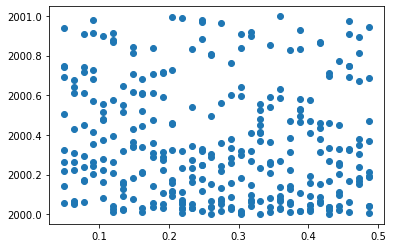

In [9]:
plt.scatter(y='ticks', x='emit-qsm-chance', data=mydf)

In [10]:
#functions to take 5-95 percentiles and mean
def percentile(n):
    def percentile_(x):
        return np.nanpercentile(x.astype(np.float64) , n)
    percentile_.__name__ = '%s' % (n)
    return percentile_

def means():
    def means_(x):
        return np.nanmean(x.astype(np.float64) )
    means_.__name__ = 'mean' 
    return means_

In [11]:
mydf['1/ticks'] = 1/mydf['ticks']
mydf['attached-or-eps'] = 1 - mydf['agent-prop-floating']

<AxesSubplot:>

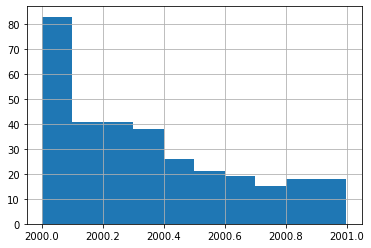

In [12]:
mydf['ticks'].hist()

In [13]:
mydf['ticks'].describe()

count     320.000000
mean     2000.350806
std         0.284981
min      2000.001612
25%      2000.094436
50%      2000.284168
75%      2000.558392
max      2000.998786
Name: ticks, dtype: float64

In [14]:
summary[var+"_mean"].hist()

NameError: name 'summary' is not defined

In [15]:
#grouping variable
var = 'mean-dist-of-particles'

#    'ticks',
#     'agent-prop-floating',
#     'agent-prop-rev-attached',
#     'agent-prop-irr-attached',
#     'agent-prop-in-eps',
#     'eps-prop'
#     'mean-dist-of-particles'
#     'attached-or-eps'


summary=mydf.groupby([ 
                      'emit-qsm-chance', 
                      'irr-attach-chance'
                    ], 
                     as_index=False)[var].agg([
    percentile(2.5),percentile(50),
    percentile(97.5),
        means()])

#reset grouping index columns
summary.columns = [var + '_%s'%col for col in summary.columns.values]
summary.reset_index(inplace=True)
#display(summary)

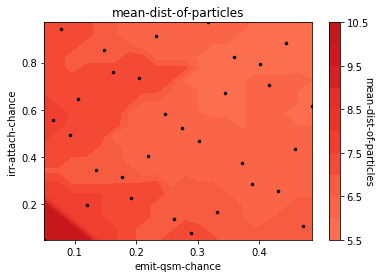

In [16]:
#plotting2
method = "Sobol"


x, y, vals = list(summary["emit-qsm-chance"]), list(summary["irr-attach-chance"]), list(summary[var+'_mean'])
# vmin, vmax = np.min(vals), np.max(vals)
vmin,vmax = 0, 14
X, Y = np.meshgrid(
    np.linspace(np.min(x), np.max(x), 20),
    np.linspace(np.min(y), np.max(y), 20)
)
cmap = mpl.cm.Reds(np.linspace(0,1,40))
cmap = mpl.colors.ListedColormap(cmap[5::])

interpolated_vals = griddata((x, y), vals, (X, Y), method='nearest', rescale=True)
plt.plot(x,y, 'k.', ms=5)
plt.title("%s"%(var))
plt.xlabel("emit-qsm-chance")
plt.ylabel("irr-attach-chance")
plt.contourf(X, Y, interpolated_vals, cmap=cmap, levels = 10, vmin=vmin, vmax=vmax)
cbar = plt.colorbar()
cbar.set_label(var, rotation=270)

# plt.tight_layout()
plt.show()

<AxesSubplot:xlabel='emit-qsm-chance', ylabel='ticks'>

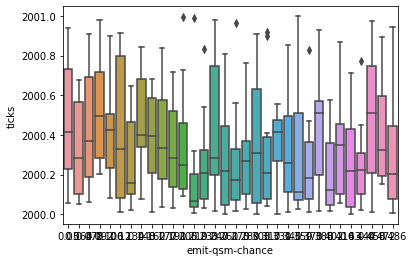

In [17]:
sns.boxplot(x='emit-qsm-chance', y='ticks', data=mydf)

<AxesSubplot:xlabel='emit-qsm-chance', ylabel='agent-prop-floating'>

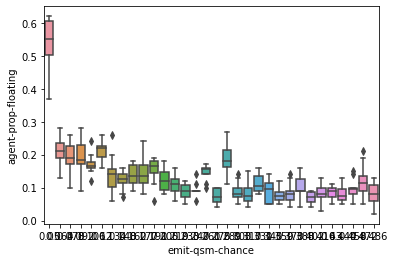

In [18]:
sns.boxplot(x='emit-qsm-chance', y='agent-prop-floating', data=mydf)

## Batch 2 - `rev-attach-chance`, `irr-attach-chance`

In [96]:
####create a summary data####


#read all data
mydf2 = pd.read_csv("model-v1 attach-sensitivity-table.csv",skiprows=6)
mydf2.columns

Index(['[run number]', 'sampling-method', 'sample_power', 'no-run',
       'detach-chance', 'smallest-particle-size', 'treatment',
       'emit-eps-chance', 'initial-number-particles', 'emit-qsm-chance',
       'qsm-lifespan', 'largest-particle-size', '[step]', 'ticks',
       'count turtles with [color != pink and not (rev-attached? or irr-attached? or in-eps?)] / count particles with [color != pink]',
       'count turtles with [color != pink and rev-attached?] / count particles with [color != pink]',
       'count turtles with [color != pink and irr-attached?] / count particles with [color != pink]',
       'count turtles with [color != pink and in-eps?] / count particles with [color != pink]',
       'count patches with [pcolor = brown] / count patches',
       'mean-dist-of-particles'],
      dtype='object')

In [97]:
mydf2.columns = [
    'run',
    'method',
    'sample-power',
    'no-run',
    'detach-chance',
    'l_size',
    'treatment',
    'emit-eps-chance',
    'initial-particles',
    'emit-qsm-chance',
    'qsm-lifespan',
    'u_size',
    'step-end',
    'ticks',
    'agent-prop-floating',
    'agent-prop-rev-attached',
    'agent-prop-irr-attached',
    'agent-prop-in-eps',
    'eps-prop',
    'mean-dist-of-particles'
]
display(mydf2)

,run,method,sample-power,no-run,detach-chance,l_size,treatment,emit-eps-chance,initial-particles,emit-qsm-chance,qsm-lifespan,u_size,step-end,ticks,agent-prop-floating,agent-prop-rev-attached,agent-prop-irr-attached,agent-prop-in-eps,eps-prop,mean-dist-of-particles
0,7,Sobol,6,0,0.2,2.5,None,1,100,0.15,50,2.5,5006,2000.500600,0.99,0.00,0.01,0.01,0.001215,12.474873
1,12,Sobol,6,1,0.2,2.5,None,1,100,0.15,50,2.5,4319,2000.385450,0.19,0.00,0.64,0.81,0.051931,7.178016
2,6,Sobol,6,0,0.2,2.5,None,1,100,0.15,50,2.5,4941,2000.086446,0.72,0.01,0.21,0.27,0.019668,10.224171
3,2,Sobol,6,0,0.2,2.5,None,1,100,0.15,50,2.5,4789,2000.117913,0.83,0.00,0.14,0.17,0.011015,11.499345
4,8,Sobol,6,0,0.2,2.5,None,1,100,0.15,50,2.5,4852,2000.214762,0.73,0.00,0.21,0.27,0.018802,11.024613
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,637,Sobol,6,63,0.2,2.5,None,1,100,0.15,50,2.5,4920,2000.577593,0.64,0.00,0.25,0.35,0.022979,11.457947
636,636,Sobol,6,63,0.2,2.5,None,1,100,0.15,50,2.5,4460,2000.177610,0.49,0.00,0.37,0.51,0.032779,9.486322
637,638,Sobol,6,63,0.2,2.5,None,1,100,0.15,50,2.5,4779,2000.606700,0.55,0.00,0.31,0.44,0.026623,9.798429
638,639,Sobol,6,63,0.2,2.5,None,1,100,0.15,50,2.5,4770,2000.484291,0.23,0.00,0.52,0.77,0.047655,7.670894


In [98]:
sobol_figs = pd.read_csv("sobol_sample_batch2.csv",sep=' ',header=None)
sobol_figs.columns = ['no-run', 'rev-attach-chance', 'irr-attach-chance']

In [99]:
mydf2 = mydf2.merge(sobol_figs, on="no-run")

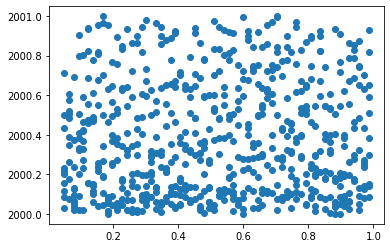

In [100]:
plt.scatter(y='ticks', x='rev-attach-chance', data=mydf2)

In [101]:
#functions to take 5-95 percentiles and mean
def percentile(n):
    def percentile_(x):
        return np.nanpercentile(x.astype(np.float64) , n)
    percentile_.__name__ = '%s' % (n)
    return percentile_

def means():
    def means_(x):
        return np.nanmean(x.astype(np.float64) )
    means_.__name__ = 'mean' 
    return means_

In [102]:
mydf2['1/ticks'] = 1/mydf2['ticks']
mydf2['attached-or-eps'] = 1 - mydf2['agent-prop-floating']

<AxesSubplot:>

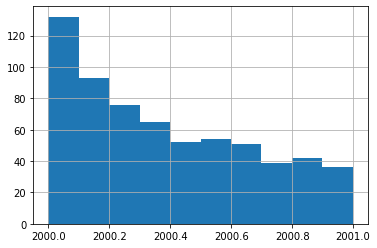

In [103]:
mydf2['ticks'].hist()

In [104]:
mydf2['ticks'].describe()

count     640.000000
mean     2000.386000
std         0.285734
min      2000.000098
25%      2000.123947
50%      2000.326261
75%      2000.612224
max      2000.999196
Name: ticks, dtype: float64

In [105]:
#grouping variable
var_list = [
    'eps-prop',
    'agent-prop-floating',
    'agent-prop-in-eps',
    'mean-dist-of-particles'
]

#    'ticks',
#     'agent-prop-floating',
#     'agent-prop-rev-attached',
#     'agent-prop-irr-attached',
#     'agent-prop-in-eps',
#     'eps-prop'
#     'mean-dist-of-particles'
#     'attached-or-eps'

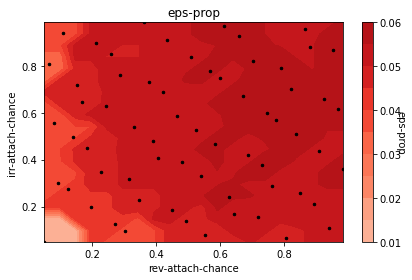

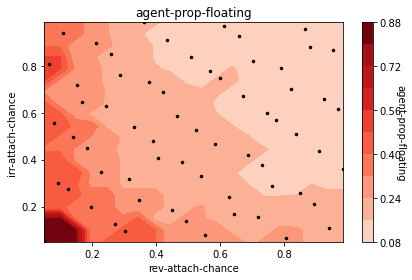

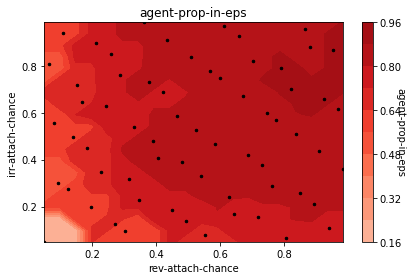

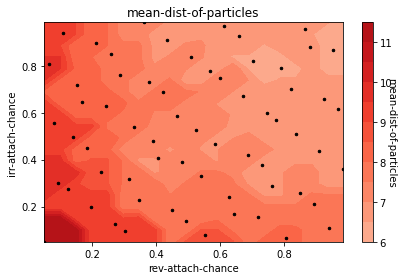

In [106]:
for var in var_list:
    summary=mydf2.groupby([ 
                          'rev-attach-chance', 
                          'irr-attach-chance'
                        ], 
                         as_index=False)[var].agg([
        percentile(2.5),percentile(50),
        percentile(97.5),
            means()])

    #reset grouping index columns
    summary.columns = [var + '_%s'%col for col in summary.columns.values]
    summary.reset_index(inplace=True)

    method = "Sobol"

    x, y, vals = list(summary["rev-attach-chance"]), list(summary["irr-attach-chance"]), list(summary[var+'_mean'])
    vmin, vmax = np.min(vals)-.25*np.mean(vals), np.max(vals)+.25*np.mean(vals)
#     vmin,vmax = 0, 1
    X, Y = np.meshgrid(
        np.linspace(np.min(x), np.max(x), 20),
        np.linspace(np.min(y), np.max(y), 20)
    )
    cmap = mpl.cm.Reds(np.linspace(0,1,40))
    cmap = mpl.colors.ListedColormap(cmap[5::])

    interpolated_vals = griddata((x, y), vals, (X, Y), method='nearest', rescale=True)
    plt.plot(x,y, 'k.', ms=5)
    plt.title("%s"%(var))
    plt.xlabel("rev-attach-chance")
    plt.ylabel("irr-attach-chance")
    plt.contourf(X, Y, interpolated_vals, cmap=cmap, levels = 10, vmin=vmin, vmax=vmax)
    cbar = plt.colorbar()
    cbar.set_label(var, rotation=270)

    plt.tight_layout()
    plt.show()

## Batch 3 - `emit-qsm-chance`, `emit-eps-chance`

In [62]:
####create a summary data####


#read all data
mydf = pd.read_csv("model-v1 attach-qs-table.csv",skiprows=6)
mydf.columns

Index(['[run number]', 'sampling-method', 'sample_power', 'no-run',
       'detach-chance', 'smallest-particle-size', 'treatment',
       'initial-number-particles', 'qsm-lifespan', 'largest-particle-size',
       'rev-attach-chance', 'irr-attach-chance', '[step]', 'ticks',
       'count turtles with [color != pink and not (rev-attached? or irr-attached? or in-eps?)] / count particles with [color != pink]',
       'count turtles with [color != pink and rev-attached?] / count particles with [color != pink]',
       'count turtles with [color != pink and irr-attached?] / count particles with [color != pink]',
       'count turtles with [color != pink and in-eps?] / count particles with [color != pink]',
       'count patches with [pcolor = brown] / count patches',
       'mean-dist-of-particles'],
      dtype='object')

In [63]:
mydf.columns = [
    'run',
    'method',
    'sample-power',
    'no-run',
    'detach-chance',
    'l_size',
    'treatment',
    'initial-particles',
    'qsm-lifespan',
    'u_size',
    'rev-attach-chance',
    'irr-attach-chance',
    'step-end',
    'ticks',
    'agent-prop-floating',
    'agent-prop-rev-attached',
    'agent-prop-irr-attached',
    'agent-prop-in-eps',
    'eps-prop',
    'mean-dist-of-particles'
]
display(mydf)

,run,method,sample-power,no-run,detach-chance,l_size,treatment,initial-particles,qsm-lifespan,u_size,rev-attach-chance,irr-attach-chance,step-end,ticks,agent-prop-floating,agent-prop-rev-attached,agent-prop-irr-attached,agent-prop-in-eps,eps-prop,mean-dist-of-particles
0,5,Sobol,6,0,0.2,2.5,None,100,50,2.5,0.75,0.05,3508,2000.447472,0.90,0.01,0.09,0.03,0.002413,11.596916
1,4,Sobol,6,0,0.2,2.5,None,100,50,2.5,0.75,0.05,3571,2000.567421,0.90,0.07,0.03,0.00,0.000000,12.544647
2,7,Sobol,6,0,0.2,2.5,None,100,50,2.5,0.75,0.05,3549,2000.160512,0.86,0.06,0.08,0.03,0.002429,11.700881
3,10,Sobol,6,0,0.2,2.5,None,100,50,2.5,0.75,0.05,3425,2000.239316,0.79,0.08,0.13,0.00,0.000000,11.843486
4,6,Sobol,6,0,0.2,2.5,None,100,50,2.5,0.75,0.05,3507,2000.403187,0.85,0.04,0.11,0.05,0.002080,11.531373
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,639,Sobol,6,63,0.2,2.5,None,100,50,2.5,0.75,0.05,3549,2000.895019,0.52,0.00,0.36,0.46,0.025924,10.004133
636,638,Sobol,6,63,0.2,2.5,None,100,50,2.5,0.75,0.05,3574,2000.085409,0.47,0.01,0.45,0.51,0.032763,9.593715
637,640,Sobol,6,63,0.2,2.5,None,100,50,2.5,0.75,0.05,3598,2000.215943,0.47,0.01,0.39,0.50,0.027921,9.861388
638,629,Sobol,6,62,0.2,2.5,None,100,50,2.5,0.75,0.05,11165,2000.353461,0.22,0.00,0.56,0.78,0.047222,7.608560


In [64]:
sobol_figs = pd.read_csv("sobol_sample.csv",sep=' ',header=None)
sobol_figs.columns = ['no-run', 'emit-qsm-chance', 'emit-eps-chance']

In [65]:
mydf = mydf.merge(sobol_figs, on="no-run")

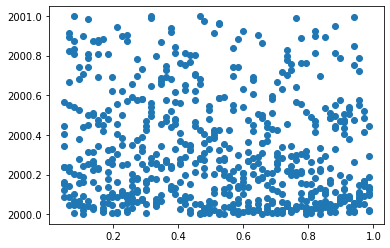

In [66]:
plt.scatter(y='ticks', x='emit-qsm-chance', data=mydf)

In [67]:
#functions to take 5-95 percentiles and mean
def percentile(n):
    def percentile_(x):
        return np.nanpercentile(x.astype(np.float64) , n)
    percentile_.__name__ = '%s' % (n)
    return percentile_

def means():
    def means_(x):
        return np.nanmean(x.astype(np.float64) )
    means_.__name__ = 'mean' 
    return means_

In [68]:
mydf['1/ticks'] = 1/mydf['ticks']
mydf['attached-or-eps'] = 1 - mydf['agent-prop-floating']
mydf['1/mean-dist-of-particles'] = 1/mydf['mean-dist-of-particles']

<AxesSubplot:>

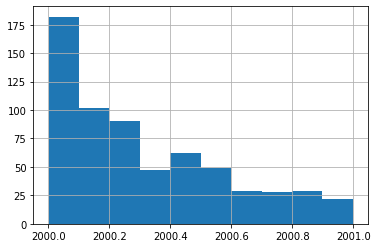

In [69]:
mydf['ticks'].hist()

In [70]:
mydf['ticks'].describe()

count     640.000000
mean     2000.316121
std         0.270243
min      2000.001462
25%      2000.085207
50%      2000.239266
75%      2000.493855
max      2000.998624
Name: ticks, dtype: float64

In [73]:
#grouping variable
var_list = [
    'eps-prop',
    'agent-prop-in-eps',
    '1/mean-dist-of-particles'
]

#    'ticks',
#     'agent-prop-floating',
#     'agent-prop-rev-attached',
#     'agent-prop-irr-attached',
#     'agent-prop-in-eps',
#     'eps-prop',
#     'mean-dist-of-particles',
#     'attached-or-eps',

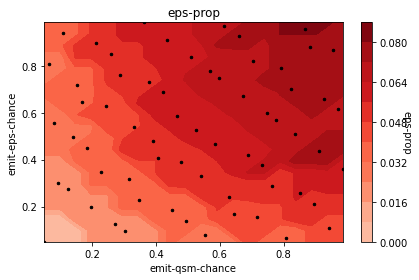

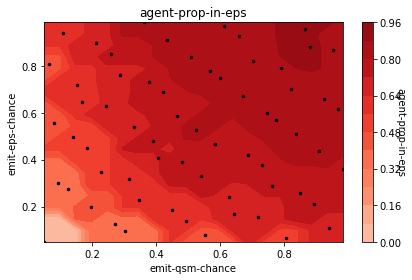

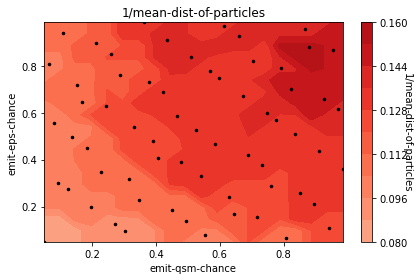

In [74]:
for var in var_list:
    summary=mydf.groupby([ 
                          'emit-qsm-chance', 
                          'emit-eps-chance'
                        ], 
                         as_index=False)[var].agg([
        percentile(2.5),percentile(50),
        percentile(97.5),
            means()])

    #reset grouping index columns
    summary.columns = [var + '_%s'%col for col in summary.columns.values]
    summary.reset_index(inplace=True)

    method = "Sobol"

    x, y, vals = list(summary["emit-qsm-chance"]), list(summary["emit-eps-chance"]), list(summary[var+'_mean'])
    vmin, vmax = np.min(vals)-.25*np.mean(vals), np.max(vals)+.25*np.mean(vals)
#     vmin,vmax = 0, 1
    X, Y = np.meshgrid(
        np.linspace(np.min(x), np.max(x), 20),
        np.linspace(np.min(y), np.max(y), 20)
    )
    cmap = mpl.cm.Reds(np.linspace(0,1,40))
    cmap = mpl.colors.ListedColormap(cmap[5::])

    interpolated_vals = griddata((x, y), vals, (X, Y), method='nearest', rescale=True)
    plt.plot(x,y, 'k.', ms=5)
    plt.title("%s"%(var))
    plt.xlabel("emit-qsm-chance")
    plt.ylabel("emit-eps-chance")
    plt.contourf(X, Y, interpolated_vals, cmap=cmap, levels = 10, vmin=vmin, vmax=vmax)
    cbar = plt.colorbar()
    cbar.set_label(var, rotation=270)

    plt.tight_layout()
    plt.show()

### Grouped analysis + graphics

In [107]:
#mydf2 is batch 2; mydf is batch 3

In [108]:
mydf['1/ticks'] = 1/mydf['ticks']
mydf['attached-or-eps'] = 1 - mydf['agent-prop-floating']
mydf['1/mean-dist-of-particles'] = 1/mydf['mean-dist-of-particles']

mydf2['1/ticks'] = 1/mydf2['ticks']
mydf2['attached-or-eps'] = 1 - mydf2['agent-prop-floating']
mydf2['1/mean-dist-of-particles'] = 1/mydf2['mean-dist-of-particles']

In [109]:
var_list = [
    'eps-prop',
    'agent-prop-in-eps',
    '1/mean-dist-of-particles'
]

In [120]:
var_dict = {
    'eps-prop': "Proportion of EPS in system (%)",
    'agent-prop-in-eps': "Proportion of agents in EPS matrix (%)",
    '1/mean-dist-of-particles': "Inverse of mean shortest particle distance"
}

In [129]:
title_dict = {
    'eps-prop': "Proportion of EPS in system",
    'agent-prop-in-eps': "Proportion of agents in EPS matrix",
    '1/mean-dist-of-particles': "Inverse of mean shortest particle distance"
}

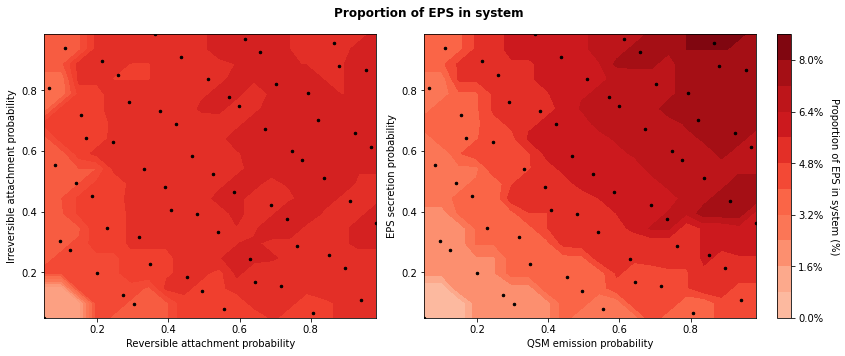

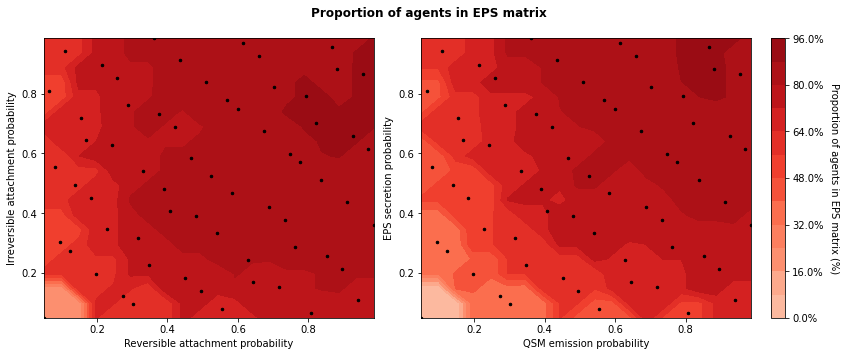

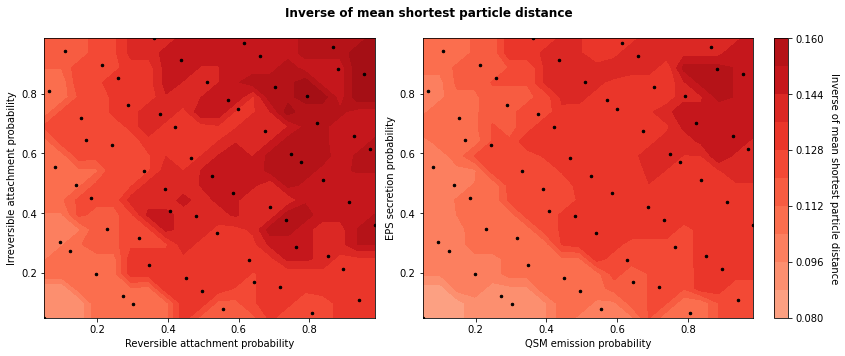

In [223]:
for var in var_list:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'width_ratios': [1, 1.25]})
    
    ## batch 2
    summary=mydf2.groupby([ 
                          'rev-attach-chance', 
                          'irr-attach-chance'
                        ], 
                         as_index=False)[var].agg([
        percentile(2.5),percentile(50),
        percentile(97.5),
            means()])

    #reset grouping index columns
    summary.columns = [var + '_%s'%col for col in summary.columns.values]
    summary.reset_index(inplace=True)

    x, y, vals = list(summary["rev-attach-chance"]), list(summary["irr-attach-chance"]), list(summary[var+'_mean'])
    X, Y = np.meshgrid(
        np.linspace(np.min(x), np.max(x), 20),
        np.linspace(np.min(y), np.max(y), 20)
    )
    interpolated_vals = griddata((x, y), vals, (X, Y), method='nearest', rescale=True)
    
    ## batch 3
    summary=mydf.groupby([ 
                          'emit-qsm-chance', 
                          'emit-eps-chance'
                        ], 
                         as_index=False)[var].agg([
        percentile(2.5),percentile(50),
        percentile(97.5),
            means()])

    #reset grouping index columns
    summary.columns = [var + '_%s'%col for col in summary.columns.values]
    summary.reset_index(inplace=True)
    
    x2, y2, vals2 = list(summary["emit-qsm-chance"]), list(summary["emit-eps-chance"]), list(summary[var+'_mean'])
    vals_total = vals + vals2
    vals = vals2
    
    X2, Y2 = np.meshgrid(
        np.linspace(np.min(x2), np.max(x2), 20),
        np.linspace(np.min(y2), np.max(y2), 20)
    )
    interpolated_vals2 = griddata((x2, y2), vals2, (X2, Y2), method='nearest', rescale=True)
    
    # global settings
    vmin, vmax = np.min(vals)-.25*np.mean(vals), np.max(vals)+.25*np.mean(vals)
    
    cmap = mpl.cm.Reds(np.linspace(0,1,40))
    cmap = mpl.colors.ListedColormap(cmap[5::])
    
    # plotting left (batch 2)
    ax1.plot(x, y, 'k.', ms=5)
#     ax1.set_title("Plot1")
    ax1.set_xlabel("Reversible attachment probability")
    ax1.set_ylabel("Irreversible attachment probability")
    ax1.contourf(X, Y, interpolated_vals, cmap=cmap, levels = 10, vmin=vmin, vmax=vmax)
    
    # plotting right (batch 3)
    ax2.plot(x2, y2, 'k.', ms=5)
#     ax2.set_title("Plot2")
    ax2.set_xlabel("QSM emission probability")
    ax2.set_ylabel("EPS secretion probability")
    ax2.contourf(X2, Y2, interpolated_vals2, cmap=cmap, levels = 10, vmin=vmin, vmax=vmax)
    
    # global plotting
    fig.suptitle(title_dict[var], fontweight="bold")
    
    if "%" in var_dict[var]:
        cbar = fig.colorbar(ax2.contourf(X2, Y2, interpolated_vals2, cmap=cmap, levels = 10, vmin=vmin, vmax=vmax),
                           format=mpl.ticker.FuncFormatter(lambda a,b: str(round(a*100,1))+"%"))
    else:
        cbar = fig.colorbar(ax2.contourf(X2, Y2, interpolated_vals2, cmap=cmap, levels = 10, vmin=vmin, vmax=vmax))
    cbar.set_label(var_dict[var], rotation=270, labelpad=15)

    fig.tight_layout()
    plt.savefig("sens_anal.png",dpi=330)

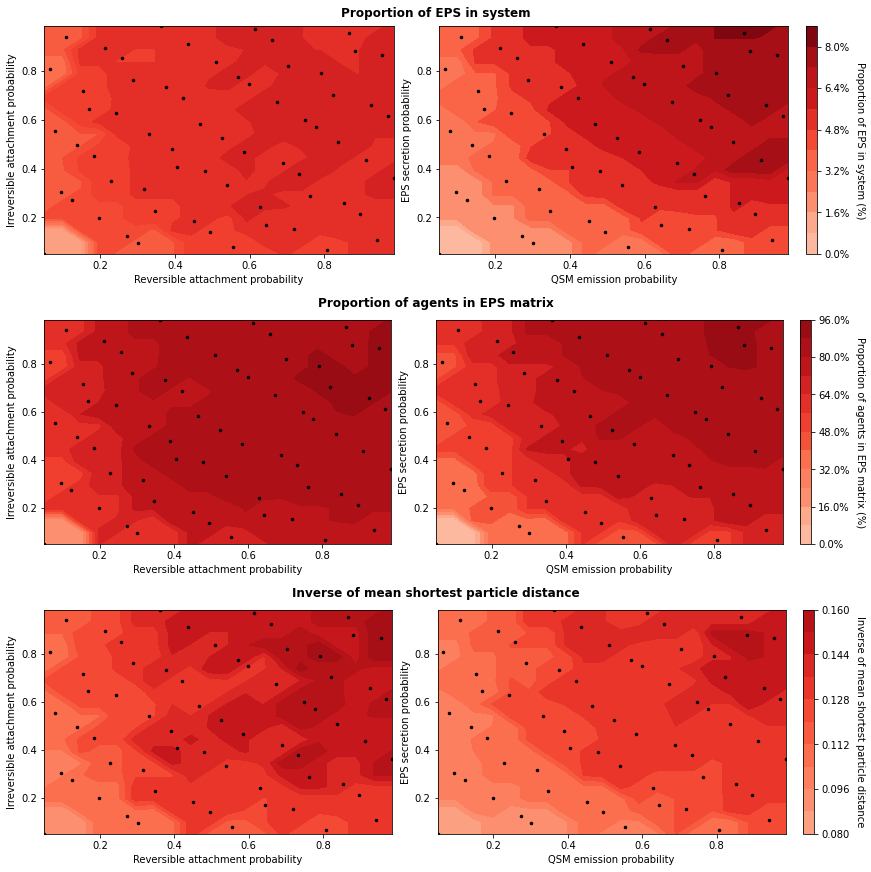

In [246]:
# fig = plt.figure(constrained_layout=True,figsize=(12,15))
fig = plt.figure(constrained_layout=True,figsize=(12,12))

subfigs = fig.subfigures(nrows=len(var_list), ncols=1)
for row, subfig in enumerate(subfigs):
    var = var_list[row]
    subfig.suptitle(title_dict[var], fontweight="bold")# global plotting
#     subfig.set_figheight(5)
#     subfig.set_figwidth(12)

    # create 1x3 subplots per subfig
    ax1, ax2 = subfig.subplots(nrows=1, ncols=2, gridspec_kw={'width_ratios': [1, 1]})
    
    ## batch 2
    summary=mydf2.groupby([ 
                          'rev-attach-chance', 
                          'irr-attach-chance'
                        ], 
                         as_index=False)[var].agg([
        percentile(2.5),percentile(50),
        percentile(97.5),
            means()])

    #reset grouping index columns
    summary.columns = [var + '_%s'%col for col in summary.columns.values]
    summary.reset_index(inplace=True)

    x, y, vals = list(summary["rev-attach-chance"]), list(summary["irr-attach-chance"]), list(summary[var+'_mean'])
    X, Y = np.meshgrid(
        np.linspace(np.min(x), np.max(x), 20),
        np.linspace(np.min(y), np.max(y), 20)
    )
    interpolated_vals = griddata((x, y), vals, (X, Y), method='nearest', rescale=True)
    
    ## batch 3
    summary=mydf.groupby([ 
                          'emit-qsm-chance', 
                          'emit-eps-chance'
                        ], 
                         as_index=False)[var].agg([
        percentile(2.5),percentile(50),
        percentile(97.5),
            means()])

    #reset grouping index columns
    summary.columns = [var + '_%s'%col for col in summary.columns.values]
    summary.reset_index(inplace=True)
    
    x2, y2, vals2 = list(summary["emit-qsm-chance"]), list(summary["emit-eps-chance"]), list(summary[var+'_mean'])
    vals_total = vals + vals2
    vals = vals2
    
    X2, Y2 = np.meshgrid(
        np.linspace(np.min(x2), np.max(x2), 20),
        np.linspace(np.min(y2), np.max(y2), 20)
    )
    interpolated_vals2 = griddata((x2, y2), vals2, (X2, Y2), method='nearest', rescale=True)
    
    # global settings
    vmin, vmax = np.min(vals)-.25*np.mean(vals), np.max(vals)+.25*np.mean(vals)
    
    cmap = mpl.cm.Reds(np.linspace(0,1,40))
    cmap = mpl.colors.ListedColormap(cmap[5::])
    
    # plotting left (batch 2)
    ax1.plot(x, y, 'k.', ms=5)
#     ax1.set_title("Plot1")
    ax1.set_xlabel("Reversible attachment probability")
    ax1.set_ylabel("Irreversible attachment probability")
    ax1.contourf(X, Y, interpolated_vals, cmap=cmap, levels = 10, vmin=vmin, vmax=vmax)
    
    # plotting right (batch 3)
    ax2.plot(x2, y2, 'k.', ms=5)
#     ax2.set_title("Plot2")
    ax2.set_xlabel("QSM emission probability")
    ax2.set_ylabel("EPS secretion probability")
    ax2.contourf(X2, Y2, interpolated_vals2, cmap=cmap, levels = 10, vmin=vmin, vmax=vmax)
    
    if "%" in var_dict[var]:
        cbar = fig.colorbar(ax2.contourf(X2, Y2, interpolated_vals2, cmap=cmap, levels = 10, vmin=vmin, vmax=vmax),
                           format=mpl.ticker.FuncFormatter(lambda a,b: str(round(a*100,1))+"%"))
    else:
        cbar = fig.colorbar(ax2.contourf(X2, Y2, interpolated_vals2, cmap=cmap, levels = 10, vmin=vmin, vmax=vmax))
    cbar.set_label(var_dict[var], rotation=270, labelpad=15)

plt.savefig("sens_anal.png",dpi=330)